In [1]:
# using Pkg
# Pkg.activate("")

# # Packages that you need
# packages_to_install = ["MLDatasets", "Plots", "Statistics", "Distributions", "Random", "Flux", "Yao", "FLOYao", "PythonCall", "BenchmarkTools", "Dates", "FiniteDifferences"]

# for pkg in packages_to_install
#     Pkg.add(pkg)
# end

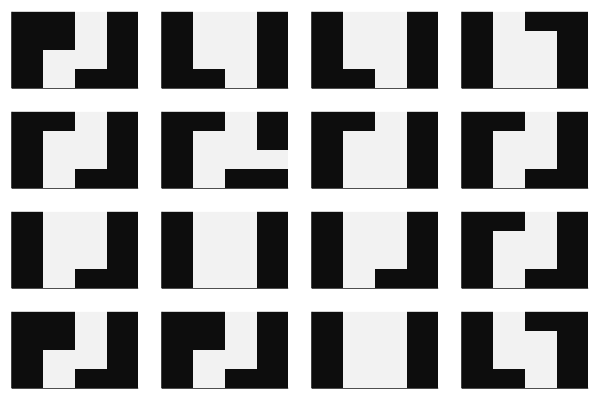

In [2]:
using MLDatasets
using Plots
using Statistics
using Distributions
using Random

train = 16 # Size of training dataset

digit = 1 # Digit to be learned
image_size = 28 # Size of image
compress_size = 4 # Size of compressed image

function compress(img, original, compress, max = true) #If max is false, then it does mean-convolution instead
    ratio = original ÷ compress
    compressed = zeros(compress, compress)
    a = []
    for i in 0:compress-1
        for j in 0:compress-1
            empty!(a)
            for p in 1:ratio
                for q in 1:ratio
                    push!(a, img[(ratio*i) + p, (ratio*j) + q])
                end
            end
            compressed[i+1, j+1] = max ? maximum(a) : mean(a)
        end
    end
    return compressed
end

train_set = MNIST(:train)
train_labels = MNIST(split=:train).targets

data_train = []
c = 1
trainstats = []
for _ in 1:train
    while train_labels[c] != digit
        c += 1
    end
    push!(data_train, compress(rotl90(train_set[c][1]), image_size, compress_size) .> 0.5)
    push!(trainstats, sum(compress(train_set[c][1], image_size, compress_size) .> 0.5))
    c += 1
end

plot([heatmap(x, color=:grays, colorbar = false, ticks = false) for x in data_train]...) #Is there any way to make this look nicer? use pythoncall and matplotlib i guess

In [35]:
using Yao
using Flux

N = compress_size^2 #Number of qubits

#Parameters are random (typically is N(0, sqrt(width)), not really sure how it's implemented)
d = Chain(Dense(N, 10, relu), Dense(10, 1, sigmoid)) 

nparams = sum(length, Flux.params(d))
println("Number of parameters in discriminator: $nparams")

layers = 5
g = chain(N)
for _ in 1:layers
    for i in 1:N-1
        push!(g, rot(kron(N, i => X, i+1 => X), 0.)) #Implemented using qiskit's definition (https://qiskit.org/documentation/stubs/qiskit.circuit.library.RXXGate.html)
    end
    # for i in 1:N-1
    #     push!(g, rot(kron(N, i => Y, i+1 => Y), 0.))
    # end
    for i in 1:N
        push!(g, put(N, i => Rz(0.)))
    end
end

nparams = nparameters(g)
println("Number of parameters in generator: $nparams")  
dispatch!(g, rand(nparams).*2π)
println(parameters(g))

Number of parameters in discriminator: 181


Number of parameters in generator: 155


[2.83588985599313, 6.116245419158586, 5.220887329390274, 3.4816369414608226, 1.9529745836231507, 0.6155391800747916, 5.074580881311935, 4.9496037140182025, 5.725016302931419, 2.840275310914983, 1.2260149467545203, 5.845313609113668, 3.9897145092079658, 4.596526401048941, 2.268456319799985, 2.612504280237267, 4.1792004642504645, 1.2566800457818228, 3.868504643048733, 1.0178869096236953, 2.270722600551537, 0.7799401040352276, 5.702021680811906, 0.5386929464306544, 0.7855720390306125, 5.620435592044811, 1.5647108524394893, 4.94540050301615, 5.343914177898381, 3.145739642276146, 2.0837238469286037, 2.23654689317839, 2.4761468031199527, 0.7064936520027825, 3.7540447565628092, 0.9566011061540899, 3.737254413360886, 0.36803614932251966, 6.240993058806965, 3.316198637725761, 0.7246597663849879, 5.98024972858164, 1.8079992872156119, 5.443121097860394, 3.3097450937336625, 3.084423567300905, 3.7135783256948716, 0.6823166858001568, 5.61766097740139, 0.9844442731054239, 4.0777520651170365, 2.414071

μ: 6.5
σ: 0.9660917830792959


Bool[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

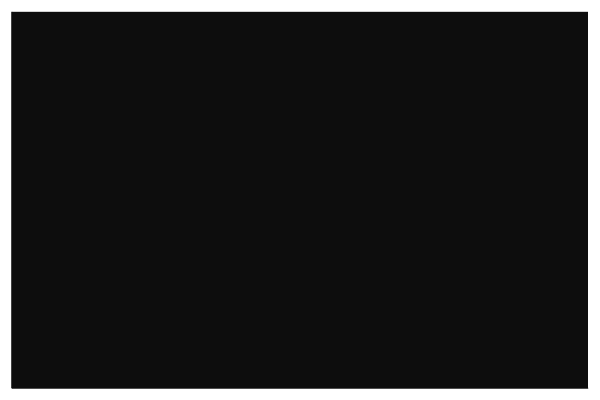

In [4]:
using FLOYao
using Random
using Distributions

mu = mean(trainstats)
sigma = std(trainstats)
println("μ: $mu")
println("σ: $sigma")
#dist = Normal(mu, sigma/20)
dist = Normal(mu, 1)

#ratio = rand(dist) / N
ratio = 0
function pprior() #For each square, probability ratio that it's white, where ratio ~ N(mean(data), std(data)) /  N; maybe we can vary pprior later?
    a = rand(N) .< ratio
    return FLOYao.product_state(Int.(a)) #Returns MajoranaReg; Prepares it to be sent through the generator 
end

pprior_example = rand(N) .< ratio
print(pprior_example)
heatmap(rotl90(reshape(pprior_example, compress_size, compress_size)) .> 0.5, color=:grays, colorbar = false, ticks = false)

In [33]:
using Flux: train!
using Yao
using FLOYao
using Statistics

function postprocess(g_output::Vector) #turns the output of reg |> g |> measure into an Int vector
    result = []
    for i in 1:N 
        push!(result, g_output[1][end - i + 1])
    end
    Int.(result)
end

samplemean_batch = 5000
function run_g(nbatch = samplemean_batch)
    samples = []
    for i in 1:nbatch
        z = pprior() #MajoranaReg object
        result = z |> g |> measure |> postprocess
        if i == 1
            samples = result
        else
            samples = hcat(samples, result) #is this operation slow; on another note there has to be a better way to write this function right
        end
    end
    samples
end
#outputs an N * #samples matrix

function run_d_fake(samples)
    if size(samples)[1] != N || typeof(samples) != Matrix{Int64} #Require samples to be an N x #samples matrix
        println("Improper formatting of samples")
        return
    end
    samples |> d
end

function run_d_real() #Runs d on all training data
    samples = []
    for i in 1:train
        result = data_train[i] |> vec
        if i == 1
            samples = result
        else
            samples = hcat(samples, result)
        end
    end
    samples |> d
end

function gLoss(nbatch = samplemean_batch)
    -mean(log.(run_d_fake(run_g(nbatch))))
end

#Ideally... but how do u get gradients to go down? do we just not use flux train? tbh i'm ok with that 
function dLoss(nbatch = samplemean_batch)
    real = mean(log.(run_d_real()))
    fake = mean(log.(1 .- run_d_fake(run_g(nbatch))))
    -(real + fake)
end

#This is only formatted like this in order to use Flux.train!
#So maybe I shouldn't use it?
# function dLoss(m, real, fake) #m is the discriminator, real is the actual data, fake is G(z) where z is sampled from pprior()
#     -(log.(m(real)) + log.(1 .- m(fake))) |> first
# end

@time gLoss() #It's still decently spread out...

  0.803643 seconds (5.24 M allocations: 2.295 GiB, 22.69% gc time, 17.12% compilation time: 17% of which was recompilation)


1.5929751f0

In [31]:
using Yao
using FLOYao

eps = 1e-5
function finitediff_grad(eps = eps) #Computes forward finite differences
    original = gLoss()
    println("original loss: $original")
    temp_params = parameters(g)
    grad = zeros(nparameters(g))
    temp = 0
    for i in 1:nparameters(g)
        plus = 0
        temp = parameters(g)[i]
        temp_params[i] = temp + eps
        dispatch!(g, temp_params)
        plus = gLoss()
        grad[i] = (plus - original) / eps #(L(θ+ε_i) - L(θ))/ε; L is computed by sample means
        temp_params[i] = temp
        dispatch!(g, temp_params)
    end
    grad
end

function parametershift_grad()
    temp_params = parameters(g)
    grad = zeros(nparameters(g))
    for i in 1:nparameters(g)
        plus = 0
        minus = 0
        temp = parameters(g)[i]
        temp_params[i] = temp + 0.5 #CHECK HOW SCALING WORKS FOR PARAMETERS
        dispatch!(g, temp_params)
        plus = gLoss()
        temp_params[i] = temp - 0.5
        dispatch!(g, temp_params)
        minus = gLoss()
        grad[i] = (minus - plus) / 2
        temp_params[i] = temp
        dispatch!(g, temp_params)
    end
    grad
end

#println(finitediff_grad())
#Computing gradients is slow and also I'm still getting different results for parametershift and finitediff
#parametershift prints very small numbers and finitediff prints very big numbers...
parametershift_grad()

In [21]:
g_lr = 1
d_lr = 0.5

opt_flag = 1
if opt_flag == 1
    d_opt = Flux.setup(Adam(), d) 
elseif opt_flag == 2
    d_opt = Flux.setup(Descent(d_lr), d) #lol is this right
elseif opt_flag == 3
    d_opt = Flux.setup(SGD(), d) #yeah idk anymore
end

gLoss_values = []
dLoss_values = []
g_epochs = 50
d_epochs = 3
epochs = 10

fake_samples = []
for m in 1:batch_size
    z = pprior()
    push!(fake_samples, z)
end

for i in 1:epochs
    t = time()
    for j in 1:g_epochs
        s = 0
        grads = []
        for m in 1:batch_size #Taking a mean of batch_size gradients because the gradients will be different because gLoss is not a function bc we can't compute that expectaiton
            z = fake_samples[m]
            push!(grads, parametershift_grad())
            s += gLoss(z)
        end
        # if norm(mean(grads)) > 100
        #     break outerloop
        dispatch!(-, g, mean(grads) * g_lr)
        push!(gLoss_values, s / batch_size)
    end
    for j in 1:d_epochs
        real = []
        fake = []
        for m in 1:batch_size
            x = data_train[m] |> vec 
            push!(real, Int.(x))
            z = pprior()
            push!(fake, convertgd(z |> g |> measure))
        end
        data = collect(zip(real, fake)) 
        Flux.train!(dLoss, d, data, d_opt)
        s = 0
        for x in data
            s += dLoss(d, x[1], x[2])        
        end
        push!(dLoss_values, s / batch_size)
    end
    println("iteration $i done in: ", time() - t)
end

iteration 1 done in: 31.244795083999634
iteration 2 done in: 

28.830497980117798


iteration 3 done in: 26.223610162734985
iteration 4 done in: 

26.45985698699951


iteration 5 done in: 27.505091190338135
iteration 6 done in: 

26.654008150100708


iteration 7 done in: 26.741831064224243
iteration 8 done in: 

26.26559805870056


iteration 9 done in: 26.217809915542603
iteration 10 done in: 

26.8448429107666


Generator loss


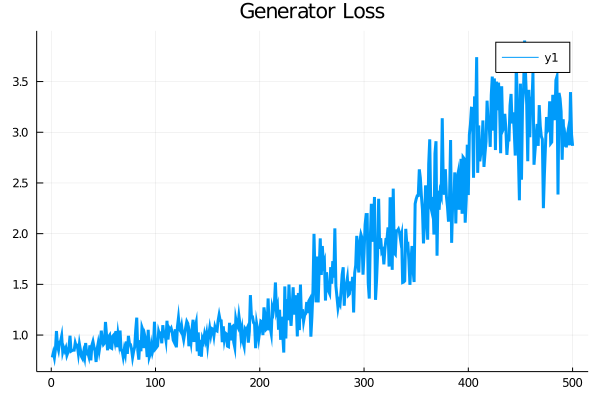

In [22]:
println("Generator loss")

# for l in gLoss_values
#     println(l)
# end

plot(gLoss_values, title = "Generator Loss", linewidth=3)

Discriminator loss


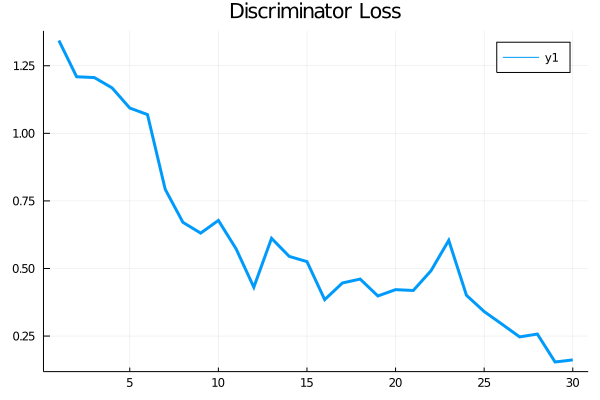

In [23]:
println("Discriminator loss")

# for l in dLoss_values
#     println(l)
# end

plot(dLoss_values, title = "Discriminator Loss", linewidth=3)

In [24]:
#Testing the Discriminator

d_fake = run_d_fake(run_g((pprior())))
println("fake data: $d_fake") #Should print a number close to 0

index = rand(1:train)
d_real = run_d_real(run_g((data_train[index])))
println("real data: $d_real") #Should print a number close to 1

fake data: 0.16437685


real data: 0.88729197


In [30]:
#Testing the Generator

nsamples = 4
samples = run_g(nsamples)
plot([heatmap(rotl90(reshape(s, compress_size, compress_size)), color=:grays, colorbar = false, ticks = false) for s in samples]...) #Not sure if the reshaping is correct but whatever

MethodError: MethodError: no method matching reshape(::Int64, ::Int64, ::Int64)

Closest candidates are:
  reshape(!Matched::Distribution{<:ArrayLikeVariate}, ::Int64, ::Int64...)
   @ Distributions ~/.julia/packages/Distributions/L19D5/src/reshaped.jl:121
  reshape(!Matched::ChainRulesCore.AbstractZero, ::Any...)
   @ ChainRulesCore ~/.julia/packages/ChainRulesCore/0t04l/src/tangent_types/abstract_zero.jl:41
  reshape(!Matched::ChainRulesCore.AbstractThunk, ::Any...)
   @ ChainRulesCore ~/.julia/packages/ChainRulesCore/0t04l/src/tangent_types/thunks.jl:58
  ...
